## Simulation

In [13]:
import numpy as np
from scipy import stats
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def calculate_release_probability(n_prisoners=4, threshold=0.75, n_sims=5*10**6):
    # Each of the 4 prisoners is assigned a random number between 0 and 1.
    nums = np.random.random(size=(n_sims, n_prisoners))
    # Prisoners flip the coin if they're above a certain threshold.
    is_flipping = nums > threshold
    # For every prisoner flipping, see if they got a 1 (heads) from a fair coin.
    flip_results = np.random.binomial(is_flipping, .5)
    # For each simulation we need to make sure at least 1 prisoner flipped.
    someone_flipped = np.any(is_flipping, axis=1)
    # Every prisoner who flipped must have gotten heads in order for the group to be released.
    all_heads = np.all(np.where(is_flipping, flip_results, 1), axis=1)
    
    released = someone_flipped & all_heads
    
    return np.mean(released)

In [3]:
thresholds = np.linspace(0, 1.0, 101)
p_release = np.zeros(101)

In [4]:
for i, threshold in enumerate(thresholds):
    p_release[i] = calculate_release_probability(threshold=threshold)
    
p_release

array([0.0624278, 0.064949 , 0.0674048, 0.070214 , 0.0732098, 0.0759308,
       0.0787804, 0.0820888, 0.0850426, 0.0883496, 0.0914688, 0.094956 ,
       0.0981648, 0.101569 , 0.105109 , 0.1090148, 0.1122436, 0.116211 ,
       0.120322 , 0.123948 , 0.1279138, 0.1321862, 0.1362458, 0.1400924,
       0.144469 , 0.148706 , 0.1529722, 0.1571556, 0.161479 , 0.1660564,
       0.170351 , 0.1747232, 0.179091 , 0.1835674, 0.1884024, 0.1925852,
       0.196893 , 0.2015118, 0.2057426, 0.2099778, 0.2143238, 0.2187436,
       0.2229632, 0.2271228, 0.2313478, 0.2352036, 0.2395106, 0.2433894,
       0.2467502, 0.2503648, 0.2541962, 0.257034 , 0.2607108, 0.2635956,
       0.2663796, 0.2692296, 0.2719728, 0.2742722, 0.27624  , 0.277901 ,
       0.2797438, 0.281595 , 0.282853 , 0.2838182, 0.2844464, 0.2845638,
       0.2848748, 0.2843666, 0.2843498, 0.2830342, 0.2819328, 0.2802832,
       0.2785416, 0.276137 , 0.2728748, 0.2699184, 0.2665086, 0.261881 ,
       0.257609 , 0.2519104, 0.2462904, 0.2401548, 

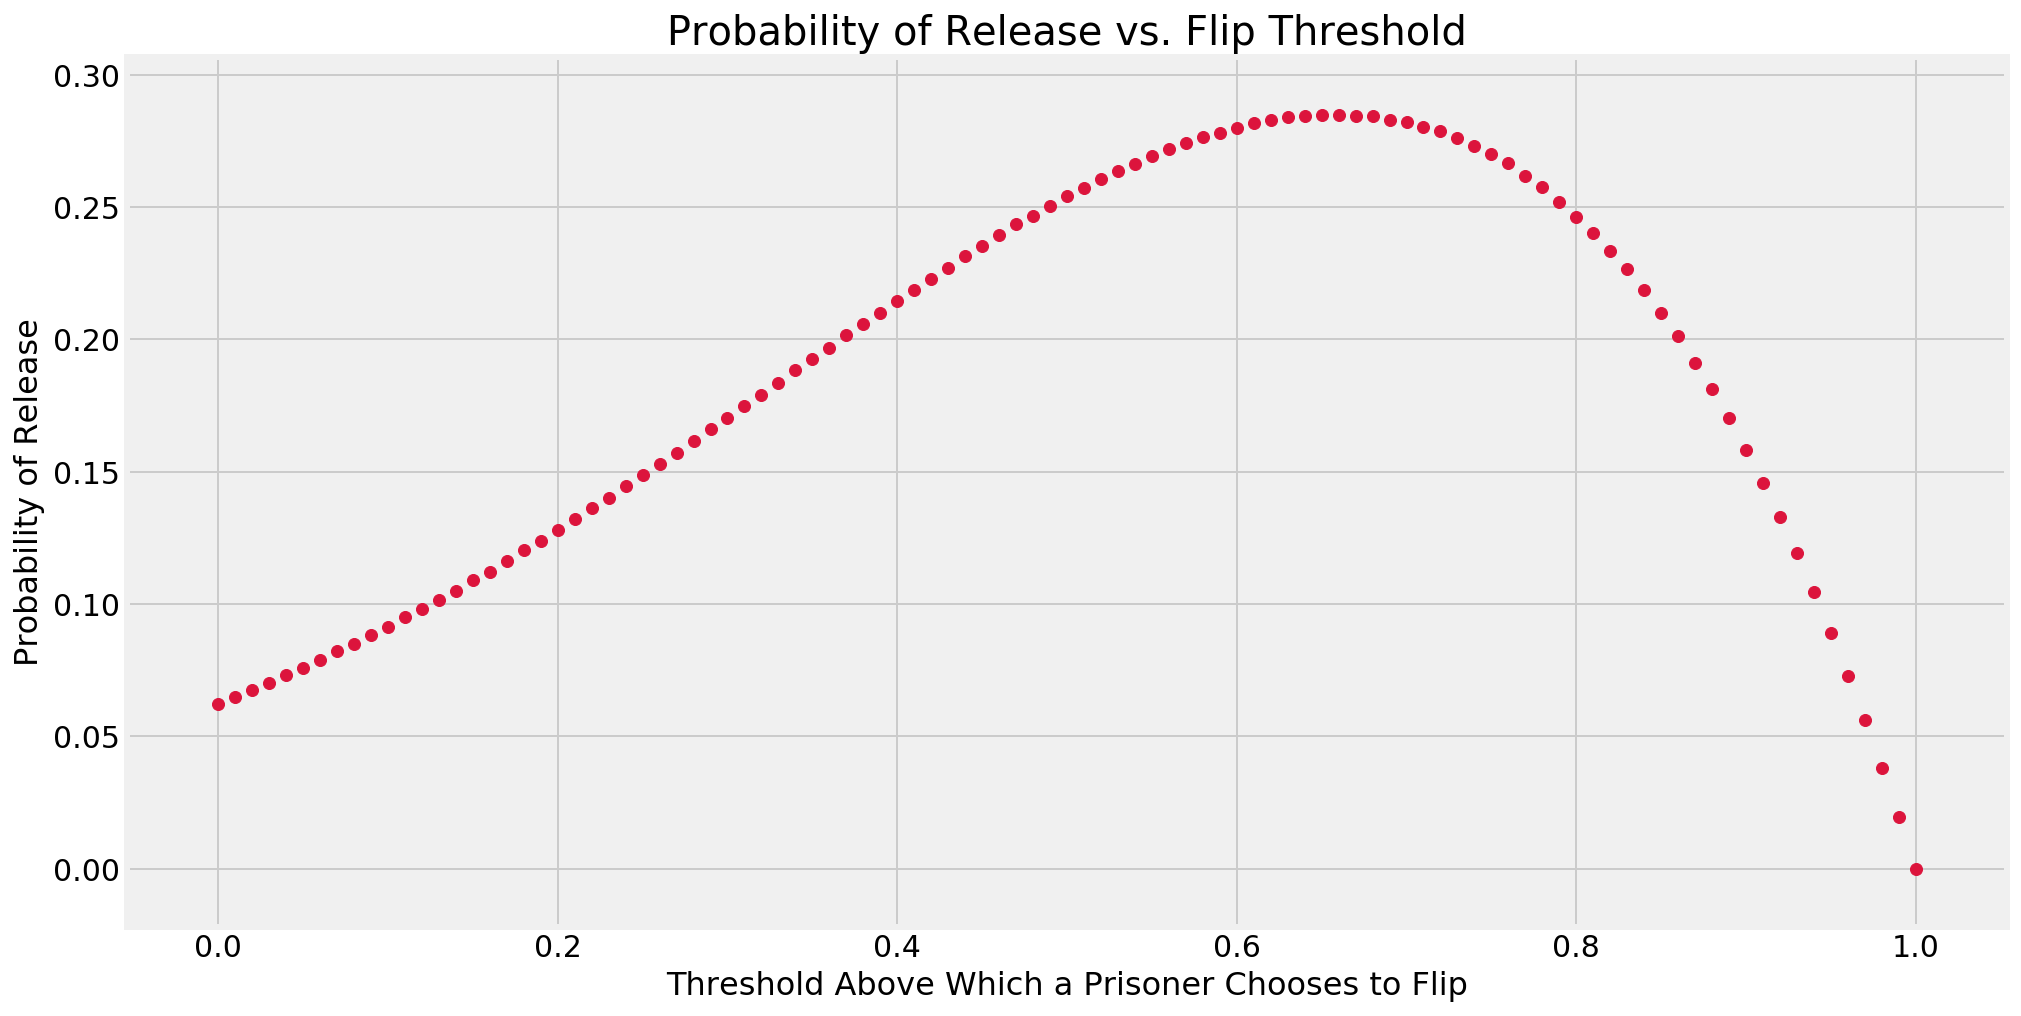

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(thresholds, p_release, color='crimson')
ax.set_title('Probability of Release vs. Flip Threshold', fontsize=20)
ax.set_ylabel('Probability of Release', fontsize=16)
ax.tick_params(axis='y', labelsize=15);
ax.set_xlabel('Threshold Above Which a Prisoner Chooses to Flip', fontsize=16)
ax.tick_params(axis='x', labelsize=15);

In [75]:
def get_prob_release_for_threshold(threshold, n_prisoners=4):
    num_flips = np.arange(1, n_prisoners+1)
    dist = stats.binom(n_prisoners, (1-threshold))
    p_num_flips = dist.pmf(num_flips)
    
    dist = stats.binom(num_flips, 0.5)
    p_all_heads = dist.pmf(num_flips)
    
    return np.sum(p_num_flips * p_all_heads)

In [76]:
def get_best_prob_release(n_prisoners=4):
    thresholds = np.linspace(0, 1.0, 1001)
    p_release = np.zeros(1001)
    
    for i, threshold in enumerate(thresholds):
        p_release[i] = get_prob_release_for_threshold(threshold, n_prisoners=n_prisoners)
        
    best_i = np.argmax(p_release)
    # Let's return both the probability of release along with the threshold above which a prisoner should flip.
    return np.max(p_release), np.argmax(p_release)/1000

In [86]:
get_best_prob_release(n_prisoners=4)

(0.284842366785, 0.658)